# MNIST Classification using Quantum Convolution

This too follows from the pennylane tutorial based on Quantum Convolution. First I use the same model as prescribed in the tutorial. In the second part of the notebook, I try to leverage the benefits of the classical ResNet Model

In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.7 MB/s eta 0:00:00


In [2]:
!pip install seaborn

2024-08-02 16:25:58.239524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 16:25:58.239663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 16:25:58.405974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


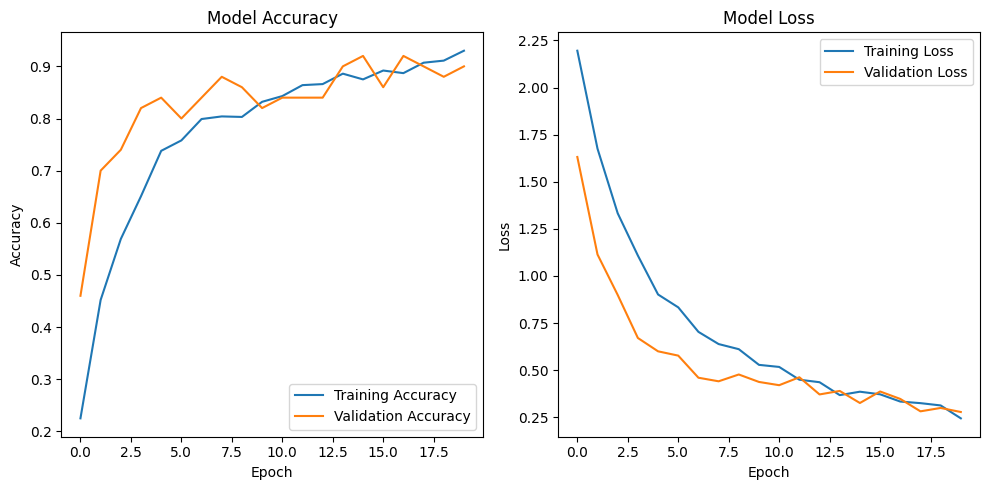

Test accuracy: 0.9000


In [3]:
import pennylane as qml
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
n_epochs = 20
n_qubits = 6
n_train = 1000# Using a samll subset as the image processing tiume with quantum convultion is very high
n_test = 50
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images[:n_train] / 255.0
test_images = test_images[:n_test] / 255.0
train_labels = train_labels[:n_train]
test_labels = test_labels[:n_test]
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def quantum_circuit(inputs):

    for i in range(n_qubits):
        qml.RY(np.pi * inputs[i], wires=i)

    for _ in range(2):
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i+1) % n_qubits])

    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)
        qml.RZ(inputs[i], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def quantum_convolution(image):
    output = np.zeros((14, 14, n_qubits))
    for i in range(0, 28, 2):
        for j in range(0, 28, 2):
            patch = image[i:i+2, j:j+2].flatten()
            padded_patch = np.pad(patch, (0, n_qubits - 4), 'constant')
            result = quantum_circuit(padded_patch)
            output[i//2, j//2] = result
    return output

q_train_images = np.array([quantum_convolution(img) for img in train_images])
q_test_images = np.array([quantum_convolution(img) for img in test_images])

# Classical model 
def create_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(14, 14, n_qubits)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
history = model.fit(q_train_images, train_labels, epochs=n_epochs, validation_data=(q_test_images, test_labels), verbose=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model
test_loss, test_accuracy = model.evaluate(q_test_images, test_labels, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

To further improve the model, I decided to leverage the benefits of Quantum Convolution, along with the Classical ResNet Mo.del

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.1824 - loss: 3.9724 - val_accuracy: 0.1600 - val_loss: 2.2796
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4419 - loss: 1.5761 - val_accuracy: 0.2550 - val_loss: 2.2284
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6514 - loss: 1.0520 - val_accuracy: 0.3050 - val_loss: 2.2377
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7631 - loss: 0.7506 - val_accuracy: 0.2250 - val_loss: 2.1528
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8554 - loss: 0.5302 - val_accuracy: 0.3250 - val_loss: 2.0153
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8808 - loss: 0.3858 - val_accuracy: 0.5000 - val_loss: 1.5213
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8614 - loss: 0.4461 - val_accuracy: 0.5400 - val_loss: 1.4048
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9166 - loss: 0.2773 - val_accuracy: 0.6800 - 

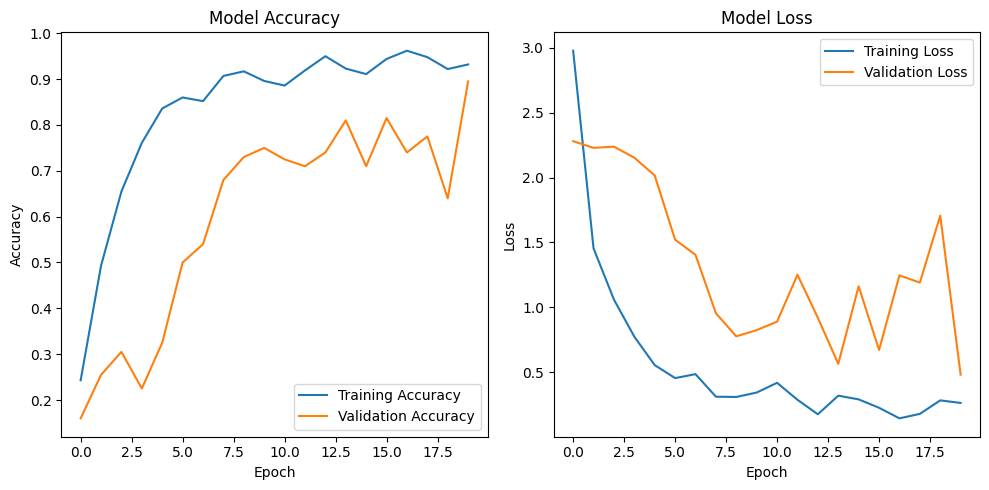

Test accuracy: 0.8950


In [4]:
import pennylane as qml
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

n_epochs = 20
n_qubits = 8
n_train = 1000
n_test = 200

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images[:n_train] / 255.0
test_images = test_images[:n_test] / 255.0
train_labels = train_labels[:n_train]
test_labels = test_labels[:n_test]

dev = qml.device("lightning.qubit", wires=n_qubits)
@qml.qnode(dev)
def quantum_circuit(inputs):
    for i in range(n_qubits):
        qml.RY(np.pi * inputs[i], wires=i)
    for _ in range(2):
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i+1) % n_qubits])
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)
        qml.RZ(inputs[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def quantum_convolution(image):
    output = np.zeros((14, 14, n_qubits))
    for i in range(0, 28, 2):
        for j in range(0, 28, 2):
            patch = image[i:i+2, j:j+2].flatten()
            padded_patch = np.pad(patch, (0, n_qubits - 4), 'constant')
            result = quantum_circuit(padded_patch)
            output[i//2, j//2] = result
    return output

q_train_images = np.array([quantum_convolution(img) for img in train_images])
q_test_images = np.array([quantum_convolution(img) for img in test_images])

# ResNet-inspired Classical Model
def quantum_conv_block(x, filters, kernel_size=3, stride=1):
    x = keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    return x

def quantum_identity_block(x, filters):
    shortcut = x
    x = quantum_conv_block(x, filters[0], kernel_size=1)
    x = quantum_conv_block(x, filters[1], kernel_size=3)
    x = quantum_conv_block(x, filters[2], kernel_size=1)
    x = keras.layers.Add()([shortcut, x])
    x = keras.layers.Activation('relu')(x)
    return x

def quantum_conv_identity_block(x, filters, stride=2):
    shortcut = quantum_conv_block(x, filters[2], kernel_size=1, stride=stride)
    x = quantum_conv_block(x, filters[0], kernel_size=1, stride=stride)
    x = quantum_conv_block(x, filters[1], kernel_size=3)
    x = quantum_conv_block(x, filters[2], kernel_size=1)
    x = keras.layers.Add()([shortcut, x])
    x = keras.layers.Activation('relu')(x)
    return x

# The Hybrid ResNet-inspired model
def create_quantum_resnet_model():
    inputs = keras.Input(shape=(14, 14, n_qubits))

    x = quantum_conv_block(inputs, 64, kernel_size=7, stride=2)
    x = keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
    x = quantum_conv_identity_block(x, [64, 64, 256])
    x = quantum_identity_block(x, [64, 64, 256])
    x = quantum_identity_block(x, [64, 64, 256])

    x = quantum_conv_identity_block(x, [128, 128, 512])
    x = quantum_identity_block(x, [128, 128, 512])
    x = quantum_identity_block(x, [128, 128, 512])

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_quantum_resnet_model()
history = model.fit(q_train_images, train_labels, epochs=n_epochs, batch_size=32,
                    validation_data=(q_test_images, test_labels), verbose=1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model
test_loss, test_accuracy = model.evaluate(q_test_images, test_labels, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

As we can see the ResNet model fluctuated a lot in Training, and perhaps with higher epochs might have outperformed the previous model. But right now, its accuracy is good, but less as compared to the basic model.